# Vertebrates/Invertebrates Google scraping classifier
Using Pytorch/Fastai

In [1]:
from fastai.vision import *

In [2]:
import PIL #import Image

## Get a list of URLs

Run this in the Javascript console to download the urls into a txt
```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

In [3]:
folder = 'vertebrados'
file = 'vertebradosURL.txt'

In [4]:
folder = 'invertebrados'
file = 'invertebradosURL.txt'

You will need to run this line once per each category.

In [5]:
path = Path('data/animales')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [8]:
path.ls()  # I have uploaded the txt files into the same directory

[PosixPath('data/animales/models'),
 PosixPath('data/animales/invertebrados'),
 PosixPath('data/animales/invertebradosURL.txt'),
 PosixPath('data/animales/export.pkl'),
 PosixPath('data/animales/cleaned.csv'),
 PosixPath('data/animales/vertebradosURL.txt'),
 PosixPath('data/animales/vertebrados')]

## Download images

In [6]:
classes = ['vertebrados','invertebrados']

In [41]:
download_images(path/file, dest, max_pics=2000)

Error x-raw-image:///66cf7417aaffdbd9b467da97ec307c93dbf5d7bfde03dd9199ad715a388cfb61 No connection adapters were found for 'x-raw-image:///66cf7417aaffdbd9b467da97ec307c93dbf5d7bfde03dd9199ad715a388cfb61'
Error http://cmapspublic3.ihmc.us/rid=1PPQSKPRB-1RY08QT-1K6C/ANIMALES%20INVERTEBRADOS.cmap?rid=1PPQSKPRB-1RY08QT-1K6C&partName=htmljpeg HTTPConnectionPool(host='cmapspublic3.ihmc.us', port=80): Max retries exceeded with url: /rid=1PPQSKPRB-1RY08QT-1K6C/ANIMALES%20INVERTEBRADOS.cmap?rid=1PPQSKPRB-1RY08QT-1K6C&partName=htmljpeg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7fbecd0a5940>, 'Connection to cmapspublic3.ihmc.us timed out. (connect timeout=4)'))


In [9]:
# If you have problems download, try with `max_workers=0` to see exceptions:
#download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [37]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

vertebrados


Image data/animales/vertebrados/00000090.gif has 1 instead of 3 channels
Image data/animales/vertebrados/00000130.gif has 1 instead of 3 channels
Image data/animales/vertebrados/00000148.gif has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/animales/vertebrados/00000083.jpg'>


/home/dani/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py:1006: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


int() argument must be a string, a bytes-like object or a number, not 'tuple'


/home/dani/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py:1006: UserWarning: Couldn't allocate palette entry for transparency
  "for transparency")


int() argument must be a string, a bytes-like object or a number, not 'tuple'
Image data/animales/vertebrados/00000115.png has 4 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/animales/vertebrados/00000122.svg'>
cannot identify image file <_io.BufferedReader name='data/animales/vertebrados/00000069.svg'>
Image data/animales/vertebrados/00000091.png has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/animales/vertebrados/00000193.svg'>
cannot identify image file <_io.BufferedReader name='data/animales/vertebrados/00000187.jpg'>
cannot identify image file <_io.BufferedReader name='data/animales/vertebrados/00000158.svg'>
Image data/animales/vertebrados/00000040.gif has 1 instead of 3 channels
invertebrados


Image data/animales/invertebrados/00000011.gif has 1 instead of 3 channels
Image data/animales/invertebrados/00000055.gif has 1 instead of 3 channels


## View data

In [7]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [50]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(".", folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [11]:
data.classes

['invertebrados', 'vertebrados']

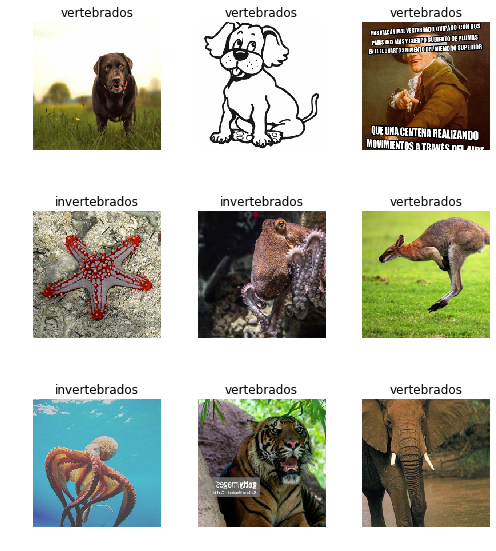

In [12]:
data.show_batch(rows=3, figsize=(7,8))

In [13]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['invertebrados', 'vertebrados'], 2, 606, 151)

## Train model

In [8]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [6]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,0.961462,0.509998,0.225166
2,0.686577,0.427266,0.165563
3,0.545727,0.383723,0.152318
4,0.463043,0.382680,0.145695


In [8]:
learn.save('stage-1')

In [9]:
learn.unfreeze()

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-04


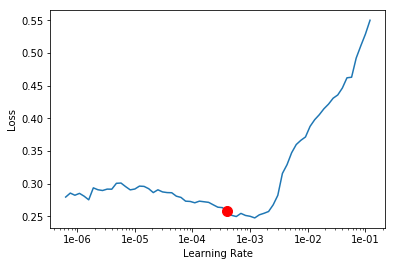

In [11]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(2, max_lr=slice(5e-5,5e-4))

epoch,train_loss,valid_loss,error_rate
1,0.290757,0.529672,0.178808
2,0.272459,0.458747,0.132450


In [13]:
learn.save('stage-2')

In [14]:
learn.fit_one_cycle(2, max_lr=slice(5e-5,5e-4))

epoch,train_loss,valid_loss,error_rate
1,0.211011,0.561994,0.125828
2,0.181157,0.565741,0.125828


In [15]:
learn.save('stage-2')

## Interpretation

In [9]:
learn.load('stage-2');

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

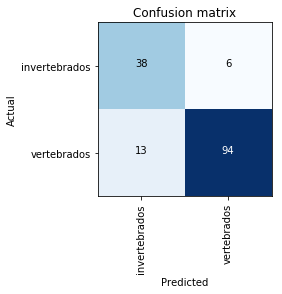

In [17]:
interp.plot_confusion_matrix()

## Cleaning Up

Using the `ImageCleaner` widget from `fastai.widgets` to prune our top losses, removing photos that don't belong.

In [18]:
from fastai.widgets import *

In [19]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [20]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Removing duplicates

In [29]:
ds, idxs = DatasetFormatter().from_similars(learn, ds_type=DatasetType.Valid)

Getting activations...


Computing similarities...


In [21]:
ImageCleaner(ds, idxs, path, duplicates=True)

## Prediction on video with OpenCV

In [13]:
img_size=256

In [10]:
def predict_frame(frame, learn):    
    # Convert frame to Tensor
    swapped = np.swapaxes(frame, -1, 0)
    swapped = np.float32(swapped / 255.)
    pixel_tensor = torch.from_numpy(swapped)
    img = Image(pixel_tensor)
    pred_class, pred_idx, outputs = learn.predict(img)
    return outputs

## Live visualization on Jupyter notebook

In [27]:
video_in = 'Animal.mp4'

%pylab inline 
import cv2
from IPython.display import clear_output

cap = cv2.VideoCapture(video_in)

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = PIL.Image.fromarray(frame)
    output = predict_frame(frame, learn)
        
    label = 'Invertebrado: {:.3}    Vertebrado: {:.3}'.format(output[0], output[1])
            
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, label, (10,50), font, 2, (255,255,255), 2, cv2.LINE_AA)
    
    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0)*(img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0)*(img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    
    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    clear_output(wait=True)

## Writing the labels and probabilities on a video

In [26]:
video_in = 'Animal.mp4'
video_out = 'output.avi'

cap = cv2.VideoCapture(video_in)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter(video_out, fourcc, cap.get(cv2.CAP_PROP_FPS), (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        
        output = predict_frame(frame, learn)
        label = 'Invertebrado: {:.3}    Vertebrado: {:.3}'.format(output[0], output[1])
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame, label, (10,50), font, 2, (255,255,255), 2, cv2.LINE_AA)

        out.write(frame)

    else:
        break   